# Time series prediction with the fastai library

Based on [fast.ai Lesson 3](https://course.fast.ai/lessons/lesson3.html) on deep learning for structured data.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch, cv2
print(torch.cuda.is_available())

True


In [3]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

In [4]:
import os
data_dir = "../../data"
raw_data_dir = os.path.join(data_dir, "raw")
assert os.path.exists(raw_data_dir)
derived_data_dir = os.path.join(data_dir, "derived")
assert os.path.exists(derived_data_dir)
PATH=derived_data_dir

In [5]:
assert os.path.exists(PATH)

In [26]:
from tqdm import tqdm as tqdm_status

## Create datasets

In [6]:
items = pd.read_csv(os.path.join(raw_data_dir, "items.csv"))
sales_train = pd.read_csv(os.path.join(raw_data_dir, "sales_train.csv"))
test = pd.read_csv(os.path.join(raw_data_dir, "test.csv"))

In [7]:
# merge in category info to the data
sales_train = sales_train.merge(items, on="item_id", how="left").drop(columns="item_name")
test = test.merge(items, on="item_id", how="left").drop(columns="item_name")

In [39]:
# manually set the date and date_block_num for the test data, which is all from November 2015
test["date"] = "11.01.2015"
test["date_block_num"] = 34
test["year"] = 2015
test["month"] = 11

In [9]:
from IPython.display import HTML, display

In [12]:
# Compatibility issue with version 0.22.0 of pandas....
#DataFrameSummary(sales_train).summary()

## Create Train Dataset

In [18]:
dates = pd.to_datetime(sales_train.date, format="%d.%m.%Y")
sales_train["year"] = [d.year for d in dates]
sales_train["month"] = [d.month for d in dates]

In [32]:
# create a new train dataset at the month level
month_cnt_list = []
processed = 0
errors = 0
for key, group in sales_train.groupby(by=["date_block_num", "year", "month", "shop_id", "item_id"]):
    processed += 1
    if processed % 100000 == 0:
        print(processed)
    if len(group) == 0:
        errors += 1
        continue
    
    date_block_num, year, month, shop_id, item_id = key
    item_cnt_month = np.sum(group.item_cnt_day)
    month_cnt_list.append({"date_block_num": date_block_num, 
                           "year": year, 
                           "month": month, 
                           "shop_id": shop_id, 
                           "item_id": item_id, 
                           "item_cnt_month": item_cnt_month})

100000
200000
300000
400000
500000


Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 893, in __del__
    self.close()
  File "/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 1104, in close
    if self.disable:
AttributeError: 'tqdm' object has no attribute 'disable'
Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 893, in __del__
    self.close()
  File "/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 1111, in close
    pos = self.pos
AttributeError: 'tqdm' object has no attribute 'pos'
Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm

600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000


NameError: name 'month_cnt_dict' is not defined

In [33]:
df = pd.DataFrame(month_cnt_list)
len(df)

1609124

In [44]:
df.sample(n=5)

,date_block_num,item_cnt_month,item_id,month,shop_id,year
556244,9,1.0,21963,10,46,2013
392581,6,1.0,14928,7,46,2013
1361661,26,1.0,16511,3,29,2015
44630,0,1.0,4573,1,42,2013
905400,16,1.0,9952,5,31,2014


In [45]:
test.sample(n=5)

,ID,shop_id,item_id,item_category_id,date,date_block_num,year,month
204113,204113,39,4055,20,11.01.2015,34,2015,11
163607,163607,36,2690,23,11.01.2015,34,2015,11
89995,89995,18,12857,40,11.01.2015,34,2015,11
36212,36212,12,1233,56,11.01.2015,34,2015,11
149605,149605,59,2884,25,11.01.2015,34,2015,11


In [48]:
train = df
train = train.merge(items, on="item_id", how="left").drop(columns="item_name")

## Data Cleaning / Feature Engineering

In [49]:
len(train),len(test)

(1609124, 214200)

In [50]:
train.head()

,date_block_num,item_cnt_month,item_id,month,shop_id,year,item_category_id
0,0,6.0,32,1,0,2013,40
1,0,3.0,33,1,0,2013,37
2,0,1.0,35,1,0,2013,40
3,0,1.0,43,1,0,2013,40
4,0,2.0,51,1,0,2013,57


In [52]:
test.drop(columns=["date"], inplace=True)
test.head()

,ID,shop_id,item_id,item_category_id,date_block_num,year,month
0,0,5,5037,19,34,2015,11
1,1,5,5320,55,34,2015,11
2,2,5,5233,19,34,2015,11
3,3,5,5232,23,34,2015,11
4,4,5,5268,20,34,2015,11


In pandas you can add new columns to a dataframe by simply defining it. We'll do this for googletrends by extracting dates and state names from the given data and adding those columns.

We're also going to replace all instances of state name 'NI' to match the usage in the rest of the data: 'HB,NI'. This is a good opportunity to highlight pandas indexing. We can use `.loc[rows, cols]` to select a list of rows and a list of columns from the dataframe. In this case, we're selecting rows w/ statename 'NI' by using a boolean list `googletrend.State=='NI'` and selecting "State".

In [17]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

The following extracts particular date fields from a complete datetime for the purpose of constructing categoricals.

You should *always* consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities. We'll add to every table with a date field.

In [18]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

The Google trends data has a special category for the whole of the Germany - we'll pull that out so we can use it explicitly.

In [19]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

Now we can outer join all of our data into a single dataframe. Recall that in outer joins everytime a value in the joining field on the left table does not have a corresponding value on the right table, the corresponding row in the new table has Null values for all right table fields. One way to check that all records are consistent and complete is to check for Null values post-join, as we do here.

*Aside*: Why note just do an inner join?
If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, in the event you are wrong or a mistake is made, an outer join followed by a null-check will catch it. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)

In [20]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [21]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [22]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [23]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [24]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [25]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

Next we'll fill in missing values to avoid complications with `NA`'s. `NA` (not available) is how Pandas indicates missing values; many models have problems when missing values are present, so it's always important to think about how to deal with them. In these cases, we are picking an arbitrary *signal value* that doesn't otherwise appear in the data.

In [26]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

Next we'll extract features "CompetitionOpenSince" and "CompetitionDaysOpen". Note the use of `apply()` in mapping a function across dataframe values.

In [27]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

We'll replace some erroneous / outlying data.

In [28]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

We add "CompetitionMonthsOpen" field, limiting the maximum to 2 years to limit number of unique categories.

In [29]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

Same process for Promo dates.

In [30]:
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [31]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [32]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

## Durations

It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

We'll define a function `get_elapsed` for cumulative counting across a sorted dataframe. Given a particular field `fld` to monitor, this function will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen. We'll see how to use this shortly.

In [33]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

We'll be applying this to a subset of columns:

In [34]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [35]:
#df = train[columns]
df = train[columns].append(test[columns])

Let's walk through an example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call `add_elapsed('SchoolHoliday', 'After')`:
This will apply to each row with School Holiday:
* A applied to every row of the dataframe in order of store and date
* Will add to the dataframe the days since seeing a School Holiday
* If we sort in the other direction, this will count the days until another holiday.

In [37]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

We'll do this for two more fields.

In [38]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [39]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

We're going to set the active index to Date.

In [40]:
df = df.set_index("Date")

Then set null values from elapsed field calculations to 0.

In [41]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [42]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)

Next we'll demonstrate window functions in pandas to calculate rolling quantities.

Here we're sorting by date (`sort_index()`) and counting the number of events of interest (`sum()`) defined in `columns` in the following week (`rolling()`), grouped by Store (`groupby()`). We do the same in the opposite direction.

In [43]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [44]:
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

Next we want to drop the Store indices grouped together in the window function.

Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

In [45]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [46]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [47]:
df.reset_index(inplace=True)

Now we'll merge these values onto the df.

In [48]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [49]:
df.drop(columns,1,inplace=True)

In [50]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,0,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,0,0,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,0,0,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,10,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,9,0,0,0,9,-1,0.0,0.0,0.0,0.0,0.0,4.0


It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [51]:
df.to_feather(f'{PATH}df')

In [52]:
df = pd.read_feather(f'{PATH}df')

In [53]:
df["Date"] = pd.to_datetime(df.Date)

In [54]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [55]:
joined = join_df(joined, df, ['Store', 'Date'])

In [56]:
joined_test = join_df(joined_test, df, ['Store', 'Date'])

The authors also removed all instances where the store had zero sale / was closed. We speculate that this may have cost them a higher standing in the competition. One reason this may be the case is that a little exploratory data analysis reveals that there are often periods where stores are closed, typically for refurbishment. Before and after these periods, there are naturally spikes in sales that one might expect. By ommitting this data from their training, the authors gave up the ability to leverage information about these periods to predict this otherwise volatile behavior.

In [57]:
joined = joined[joined.Sales!=0]

We'll back this up as well.

In [58]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [59]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

We now have our final set of engineered features.

While these steps were explicitly outlined in the paper, these are all fairly typical feature engineering steps for dealing with time series data and are practical in any similar setting.

## Create features

In [60]:
joined = pd.read_feather(f'{PATH}joined')
joined_test = pd.read_feather(f'{PATH}joined_test')

In [61]:
joined.head().T.head(40)

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

In [62]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

n = len(joined); n

844338

In [63]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

In [64]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

In [65]:
# make all categorical variables ordered Pandas categories
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [66]:
apply_cats(joined_test, joined)

In [67]:
# pyTorch expects every continuous var to be 32-bit floating point
for v in contin_vars:
    joined[v] = joined[v].fillna(0).astype('float32')
    joined_test[v] = joined_test[v].fillna(0).astype('float32')

We're going to run on a sample.

In [68]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("Date")
samp_size = len(joined_samp); samp_size

150000

To run on the full dataset, use this instead:

In [69]:
samp_size = n
joined_samp = joined.set_index("Date")

We can now process our data...

In [70]:
joined_samp.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,2015,7,31,False,24,0,c,a,...,24.0,11.0,1.0,85.0,83.0,0.0,0.0,1.0,1.0,5263
2015-07-31,2,5,2015,7,31,False,24,25,a,a,...,14.0,11.0,4.0,80.0,83.0,0.0,0.0,1.0,1.0,6064


In [71]:
# proc_df takes a dataframe and pulls out a dependent/response variable (Sales) into y.
# it also numericalizes all columns
# it also scales the input data to be approximately standard normal (the mapper lets you do that for the test data too)
# the nas: "returns a dictionary of which nas it created, and the associated median."
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)
# here, we are using the log of the sales as our response var
yl = np.log(y)

In [114]:
nas

{}

In [72]:
# added by me to investigate strange pandas error
assert not df['AfterStateHoliday'].isnull().values.any()
min(df['AfterStateHoliday'])

0.0

In [113]:
??proc_df

In [73]:
joined_test = joined_test.set_index("Date")

In [74]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)

In [75]:
df.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,3,7,31,1,25,1,3,1,...,-1.620066,0.149027,-0.142774,-1.844823,1.732492,1.724334,0.0,0.0,1.113717,2.04105
2015-07-31,2,5,3,7,31,1,25,26,1,1,...,-1.264031,-0.960613,-0.142774,-0.488722,1.294578,1.724334,0.0,0.0,1.113717,2.04105


In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

In [76]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

An even better option for picking a validation set is using the exact same length of time period as the test set uses - this is implemented here:

In [77]:
val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))

In [78]:
val_idx=[0]

In [115]:
val_idx

[0]

## DL

We're ready to put together our models.

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [116]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)
y_range

(0, 12.7616122408592)

We can create a ModelData object directly from out data frame.

In [80]:
# The parameter cat_flds says which columns are categorical; 
# we otherwise wouldn't be able to tell, as by this point we've numericalized all the columns!
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!

In [122]:
joined_samp["Day"].cat.categories

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
           dtype='int64')

In [81]:
# we add one to the number of categorical variable levels to leave room for an "unknown" level
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [82]:
cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 1),
 ('Promo_bw', 1),
 ('StateHoliday_fw', 1),
 ('StateHoliday_bw', 1),
 ('SchoolHoliday_fw', 1),
 ('SchoolHoliday_bw', 1)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [123]:
emb_szs = [(card, min(50, (card+1)//2)) for _,card in cat_sz]

In [124]:
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1)]

In [85]:
# md.get_learner(emb_szs, 
#   n_cont i.e. number of continuous variables, 
#   emb_drop i.e. droput percentage for the embedding matrix, 
#   out_sz, # how many outputs we want to create (in this case, sales is a single number)
#   szs, # [number of activations in the first linear layer, number of activations in the second linear layer]
#   drops, # [dropout in the first linear layer, dropout in the second linear layer]
#   y_range=None, use_bn=False)

m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
m.summary()

In [117]:
??md.get_learner

In [86]:
lr = 1e-3
m.lr_find()

 58%|█████▊    | 3850/6597 [00:43<00:30, 89.28it/s, loss=0.144] 

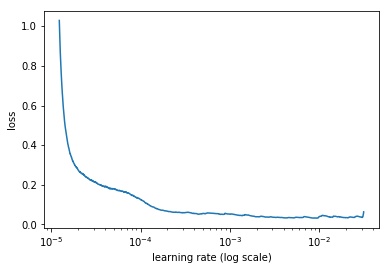

In [87]:
m.sched.plot(100)

### Sample

In [127]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [128]:
m

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(1116, 50)
    (1): Embedding(8, 4)
    (2): Embedding(4, 2)
    (3): Embedding(13, 7)
    (4): Embedding(32, 16)
    (5): Embedding(3, 2)
    (6): Embedding(26, 13)
    (7): Embedding(27, 14)
    (8): Embedding(5, 3)
    (9): Embedding(4, 2)
    (10): Embedding(4, 2)
    (11): Embedding(24, 12)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 27)
    (15): Embedding(22, 11)
    (16): Embedding(1, 1)
    (17): Embedding(1, 1)
    (18): Embedding(1, 1)
    (19): Embedding(1, 1)
    (20): Embedding(1, 1)
    (21): Embedding(1, 1)
  )
  (lins): ModuleList(
    (0): Linear(in_features=199, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=500, out_features=1, bias=True)
  (emb_dro

In [89]:
m.fit(lr, 3, metrics=[exp_rmspe])

  9%|▉         | 591/6597 [00:06<01:01, 96.88it/s, loss=0.0402]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/srivbane/levon003/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/srivbane/levon003/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.013617   0.000164   0.01272   
    1      0.011146   0.000155   0.012545                        
    2      0.009337   0.00123    0.035698                         



[array([0.00123]), 0.0356975937769956]

In [90]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.008168   0.0        0.000247  
    1      0.007519   1e-06      0.000842                        
    2      0.007632   0.000651   0.02584                         
    3      0.007295   0.002471   0.050968                        
    4      0.007365   0.000694   0.026702                        



[array([0.00069]), 0.026702197474863056]

In [91]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4)

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.007765   8.9e-05    0.009364  
    1      0.007396   0.000151   0.01223                         
    2      0.006384   0.000288   0.017104                         
    3      0.005506   0.000143   0.012044                         
    4      0.007619   0.001527   0.038325                         
    5      0.006462   0.000571   0.024178                         
    6      0.006146   0.000489   0.022348                         
    7      0.006194   0.001339   0.037277                         



[array([0.00134]), 0.037277106129939175]

### All

In [92]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [93]:
m.fit(lr, 1, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.014556   0.003559   0.061469  



[array([0.00356]), 0.06146943280374603]

In [94]:
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.013061   0.000238   0.015534  
    1      0.00997    0.001768   0.042945                         
    2      0.009058   5.4e-05    0.007293                         



[array([0.00005]), 0.007292766142011065]

In [95]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.007311   5.2e-05    0.00724   
    1      0.007395   0.000587   0.02393                          
    2      0.006389   2e-06      0.001371                         



[array([0.]), 0.0013713250973387888]

### Test

In [96]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [97]:
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.014124   0.008838   0.089725  
    1      0.010885   0.000158   0.012509                        
    2      0.009594   0.001991   0.043635                         



[array([0.00199]), 0.043635151985223164]

In [98]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.007793   2e-06      0.00145   
    1      0.00775    0.0004     0.0198                           
    2      0.007467   0.0        8.4e-05                          



[array([0.]), 8.38696869796679e-05]

In [99]:
m.save('val0')

In [100]:
m.load('val0')

In [101]:
x,y=m.predict_with_targs()

In [102]:
exp_rmspe(x,y)

8.38696869796679e-05

In [103]:
pred_test=m.predict(True)

In [104]:
pred_test = np.exp(pred_test)

In [105]:
joined_test['Sales']=pred_test

In [106]:
csv_fn=f'{PATH}tmp/sub.csv'

In [107]:
joined_test[['Id','Sales']].to_csv(csv_fn, index=False)

In [108]:
FileLink(csv_fn)

/home/srivbane/levon003/code/fastai/data/rossmann/tmp/sub.csv

## RF

In [53]:
from sklearn.ensemble import RandomForestRegressor

In [110]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, yl)

In [111]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [126]:
m

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.99, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [112]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds, y_val)

(0.9799996236781046, 0.0, 0.9163883709271708, 0.06532575144379271)

## RandomForest on Basic Formulation

In [54]:
train.head()

,date_block_num,item_cnt_month,item_id,month,shop_id,year,item_category_id
0,0,6.0,32,1,0,2013,40
1,0,3.0,33,1,0,2013,37
2,0,1.0,35,1,0,2013,40
3,0,1.0,43,1,0,2013,40
4,0,2.0,51,1,0,2013,57


In [55]:
feature_cols = ["year", "month", "shop_id", "item_id", "item_category_id"]

In [66]:
X_trn = train.loc[train.date_block_num <= 30, feature_cols]
X_val = train.loc[train.date_block_num > 30, feature_cols]  # leave months 31, 32, 33 as validation data
X_tst = test.loc[:, feature_cols]
X_trn.shape, X_val.shape, X_tst.shape

((1514429, 5), (94695, 5), (214200, 5))

In [61]:
y_trn = train[train.date_block_num <= 30].item_cnt_month
y_val = train[train.date_block_num > 30].item_cnt_month
y_trn.shape, y_val.shape

((1514429,), (94695,))

In [62]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)

In [63]:
m.fit(X_trn, y_trn)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.99, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [67]:
y_val_pred = m.predict(X_val)
m.score(X_trn, y_trn), m.score(X_val, y_val), m.oob_score_

(0.8550891991600991, 0.14068042521389035, 0.6620306131618687)

In [68]:
y_tst_pred = m.predict(X_tst)

In [71]:
output_filepath = os.path.join(derived_data_dir, "randForest_preds.csv")
with open(output_filepath, 'w') as outfile:
    outfile.write("ID,item_cnt_month\n")
    for i, test_id in enumerate(test.ID):
        pred = y_tst_pred[i]
        outfile.write("%d,%.2f\n" % (test_id, pred))
print("Finished.")

Finished.


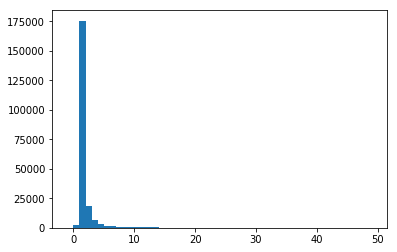

In [73]:
plt.hist(y_tst_pred, bins=range(-1, 50))
plt.show()